## Step 1: Setup

In [1]:
#@title Setup
!git clone https://github.com/oneThousand1000/HairMapper
import os
os.chdir('./HairMapper')

# ==================== download checkpoint ====================
!pip install gdown
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

print('Please wait util all models are downloaded...')


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def download_from_google_drive(file_id,file_dst):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(file_dst)

checkpoints ={
    'StyleGAN2-ada-Generator.pth':
    {
        'url':'1EsGehuEdY4z4t21o2LgW2dSsyN3rxYLJ',
        'dir': './ckpts'
    },
    'e4e_ffhq_encode.pt':
    {
        'url':'1cUv_reLE6k3604or78EranS7XzuVMWeO',
        'dir': './ckpts'
    },
    'model_ir_se50.pth':
    {
        'url':'1GIMopzrt2GE_4PG-_YxmVqTQEiaqu5L6',
        'dir': './ckpts'
    },
    'face_parsing.pth':
    {
        'url':'1IMsrkXA9NuCEy1ij8c8o6wCrAxkmjNPZ',
        'dir': './ckpts'
    },
    'vgg16.pth':
    {
        'url':'1EPhkEP_1O7ZVk66aBeKoFqf3xiM4BHH8',
        'dir': './ckpts'
    }
}
for ckpt in checkpoints:
  name = ckpt
  url = checkpoints[name]['url']
  output_dir = checkpoints[name]['dir']
  os.makedirs(output_dir,exist_ok=True)
  output_path = os.path.join(output_dir,name)
  #gdown.download(url=url,output=output_path,quiet=False) # bug
  download_from_google_drive(file_id=url, file_dst=output_path)

classification_ckpt =[
        {'url':'1SSw6vd-25OGnLAE0kuA-_VHabxlsdLXL',
        'dir': './classifier/gender_classification'},
        {'url':'1n14ckDcgiy7eu-e9XZhqQYb5025PjSpV',
        'dir': './classifier/hair_classification'}
]
for clf_ckpt_dict in classification_ckpt:
  name = 'classification_model.pth'
  url = clf_ckpt_dict['url']
  output_dir = clf_ckpt_dict['dir']
  os.makedirs(output_dir,exist_ok=True)
  output_path = os.path.join(output_dir,name)
  #gdown.download(url=url,output=output_path,quiet=False)
  download_from_google_drive(file_id=url, file_dst=output_path)





fatal: destination path 'HairMapper' already exists and is not an empty directory.


Please wait util all models are downloaded...


In [2]:
# ==================== install packages ====================
!pip install torch===2.0.0+cu117 torchvision===0.15.0+cu117 torchaudio===2.0.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -r requirements.txt
!pip install pillow==9.5.0
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached tqdm-4.60.0-py2.py3-none-any.whl.metadata (57 kB)
  Using cached requests-2.25.1-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached matplotlib-3.4.1.tar.gz (37.3 MB)
  Preparing metadata (setup.py) ... done
  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
--2025-04-05 12:10:46--  https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip


## Step 2: pre-trained models access

Please fill out this form for **pre-trained models access**: https://forms.gle/a5pRbE3yxEr7sZDm7

Then fill out the mapper_url with the url of [Final HairMapper]



In [3]:
mapper_url = 'https://drive.google.com/file/d/1F3oujXbvalqEOixcAkIyURuY512nmroe' #@param {type:"string"}

## Step 3: download pre-trained model and test image

In [5]:
#@title Download Pretrain Models

name = 'best_model.pt'
mapper_url = mapper_url.replace('https://drive.google.com/file/d/','')
output_dir = './mapper/checkpoints/final'
os.makedirs(output_dir,exist_ok=True)
output_path = os.path.join(output_dir,name)
download_from_google_drive(file_id=mapper_url, file_dst=output_path)


In [6]:
#@title Download test image
name = '00010.png'
url = '1f-cHWMczIyjYBWRnypi1brOpFf2skgWd'
output_dir = './test_data/origin'
os.makedirs(output_dir,exist_ok=True)
output_path = os.path.join(output_dir,name)
download_from_google_drive(file_id=url, file_dst=output_path)

## Step 4: Run encoder

In [7]:
os.chdir('./encoder4editing')

Please put the real images to **./test_data/origin** (examplar data can be found in ./test_data/origin/00006.png).



In [8]:
!pip install "numpy<2.0"
!pip install pillow==9.5.0

In [9]:
from argparse import Namespace
import sys
import torch
import torchvision.transforms as transforms
import numpy as np
import PIL.Image
from PIL import ImageFile
import glob
import os
import argparse
sys.path.append(".")
sys.path.append("..")
ImageFile.LOAD_TRUNCATED_IMAGES = True
from models.psp import pSp

In [10]:
def run_on_batch(inputs, net):
    latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    return latents


In [11]:
img_transforms = transforms.Compose([
          transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
            )
model_path = "../ckpts/e4e_ffhq_encode.pt"
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()

Loading e4e over the pSp framework from checkpoint: ../ckpts/e4e_ffhq_encode.pt


pSp(
  (encoder): Encoder4Editing(
    (input_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=64)
    )
    (body): Sequential(
      (0): bottleneck_IR_SE(
        (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
        (res_layer): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (2): PReLU(num_parameters=64)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): SEModule(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64

In [12]:
data_dir = '../test_data'
file_dir = os.path.join(data_dir,'origin')
code_dir = os.path.join(data_dir,'code')
if not os.path.exists(code_dir):
    os.mkdir(code_dir)
for file_path in glob.glob(os.path.join(file_dir,'*.png'))+glob.glob(os.path.join(file_dir,'*.jpg')):
    name = os.path.basename(file_path)[:-4]
    code_path =os.path.join(code_dir,f'{name}.npy')
    if os.path.exists(code_path):
        continue
    input_image = PIL.Image.open(file_path).convert('RGB')
    transformed_image = img_transforms(input_image)

    with torch.no_grad():
        latents = run_on_batch(transformed_image.unsqueeze(0), net)
        latent = latents[0].cpu().numpy()
        latent = np.reshape(latent,(1,18,512))
        np.save(code_path,latent)
        print(f'save to {code_path}')


save to ../test_data/code/00010.npy


## Step 5: Run HairMaper

In [13]:
os.chdir('../')

In [14]:
import os.path
import argparse
import cv2
from styleGAN2_ada_model.stylegan2_ada_generator import StyleGAN2adaGenerator
from tqdm import tqdm
from classifier.src.feature_extractor.hair_mask_extractor import get_hair_mask, get_parsingNet
from mapper.networks.level_mapper import LevelMapper
import torch
import glob
from diffuse.inverter_remove_hair import InverterRemoveHair
import numpy as np
from PIL import ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
model_name = 'stylegan2_ada'
latent_space_type = 'wp'
data_dir = './test_data'
print(f'Initializing generator.')
model = StyleGAN2adaGenerator(model_name, logger=None, truncation_psi=1.0)

mapper = LevelMapper(input_dim=512).eval().cuda()
ckpt = torch.load('./mapper/checkpoints/final/best_model.pt')
alpha = float(ckpt['alpha']) * 1.2
mapper.load_state_dict(ckpt['state_dict'], strict=True)
kwargs = {'latent_space_type': latent_space_type}
parsingNet = get_parsingNet(save_pth='./ckpts/face_parsing.pth')
inverter = InverterRemoveHair(
        model_name,
        Generator=model,
        learning_rate=0.01,
        reconstruction_loss_weight=1.0,
        perceptual_loss_weight=5e-5,
        truncation_psi=1.0,
        logger=None
)

code_dir = os.path.join(data_dir, 'code')
origin_img_dir = os.path.join(data_dir, 'origin')
res_dir = os.path.join(data_dir, 'mapper_res')

os.makedirs(res_dir, exist_ok=True)

Initializing generator.
Loading pytorch model from `/content/HairMapper/ckpts/StyleGAN2-ada-Generator.pth`.


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


load face_parsing model from:  ./ckpts/face_parsing.pth
loaf perceptual model from:  /content/HairMapper/ckpts/vgg16.pth


In [16]:
code_list = glob.glob(os.path.join(code_dir, '*.npy'))

total_num = len(code_list)

print(f'Editing {total_num} samples.')
pbar = tqdm(total=total_num)
for index in range(total_num):
    pbar.update(1)
    code_path = code_list[index]
    name = os.path.basename(code_path)[:-4]
    f_path_png = os.path.join(origin_img_dir, f'{name}.png')
    f_path_jpg = os.path.join(origin_img_dir, f'{name}.jpg')
    if os.path.exists(os.path.join(res_dir, f'{name}.png')):
        continue
    if os.path.exists(f_path_png):
        origin_img_path = f_path_png
    elif os.path.exists(f_path_jpg):
        origin_img_path = f_path_jpg
    else:
        continue

    latent_codes_origin = np.reshape(np.load(code_path), (1, 18, 512))

    mapper_input = latent_codes_origin.copy()
    mapper_input_tensor = torch.from_numpy(mapper_input).cuda().float()
    edited_latent_codes = latent_codes_origin
    edited_latent_codes[:, :8, :] += alpha * mapper(mapper_input_tensor).to('cpu').detach().numpy()

    origin_img = cv2.imread(origin_img_path)

    outputs = model.easy_style_mixing(latent_codes=edited_latent_codes,
                                      style_range=range(7, 18),
                                      style_codes=latent_codes_origin,
                                      mix_ratio=0.8,
                                      **kwargs
                                      )

    edited_img = outputs['image'][0][:, :, ::-1]
    #edited_img = cv2.resize(edited_img, (origin_img.shape[1], origin_img.shape[0]))

    # --remain_ear: preserve the ears in the original input image.
    hair_mask = get_hair_mask(img_path=origin_img, net=parsingNet, include_hat=True, include_ear=True)

    mask_dilate = cv2.dilate(hair_mask,
                             kernel=np.ones((50, 50), np.uint8))
    mask_dilate_blur = cv2.blur(mask_dilate, ksize=(30, 30))
    mask_dilate_blur = (hair_mask + (255 - hair_mask) / 255 * mask_dilate_blur).astype(np.uint8)

    face_mask = 255 - mask_dilate_blur
    face_mask = cv2.resize(face_mask, (origin_img.shape[1], origin_img.shape[0]))
    #if len(face_mask.shape) == 2:
    #    face_mask = cv2.cvtColor(face_mask, cv2.COLOR_GRAY2BGR)

    index = np.where(face_mask > 0)
    cy = (np.min(index[0]) + np.max(index[0])) // 2
    cx = (np.min(index[1]) + np.max(index[1])) // 2
    center = (cx, cy)

    res_save_path = os.path.join(res_dir, f'{name}.png')

    mixed_clone = cv2.seamlessClone(origin_img, edited_img, face_mask[:, :, 0], center, cv2.NORMAL_CLONE)


    cv2.imwrite(res_save_path, mixed_clone)


Editing 1 samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"...


Using /root/.cache/torch_extensions/py311_cu117 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu117/bias_act_plugin...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu117/bias_act_plugin/build.ninja...
Building extension module bias_act_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


Done setting up PyTorch plugin "bias_act_plugin".
Setting up PyTorch plugin "upfirdn2d_plugin"...


Loading extension module bias_act_plugin...
Using /root/.cache/torch_extensions/py311_cu117 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu117/upfirdn2d_plugin...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu117/upfirdn2d_plugin/build.ninja...
Building extension module upfirdn2d_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module upfirdn2d_plugin...


Done setting up PyTorch plugin "upfirdn2d_plugin".


## Step 6: visualize results

In [17]:
from IPython.display import display
import glob
import cv2
import numpy as np
from PIL import Image

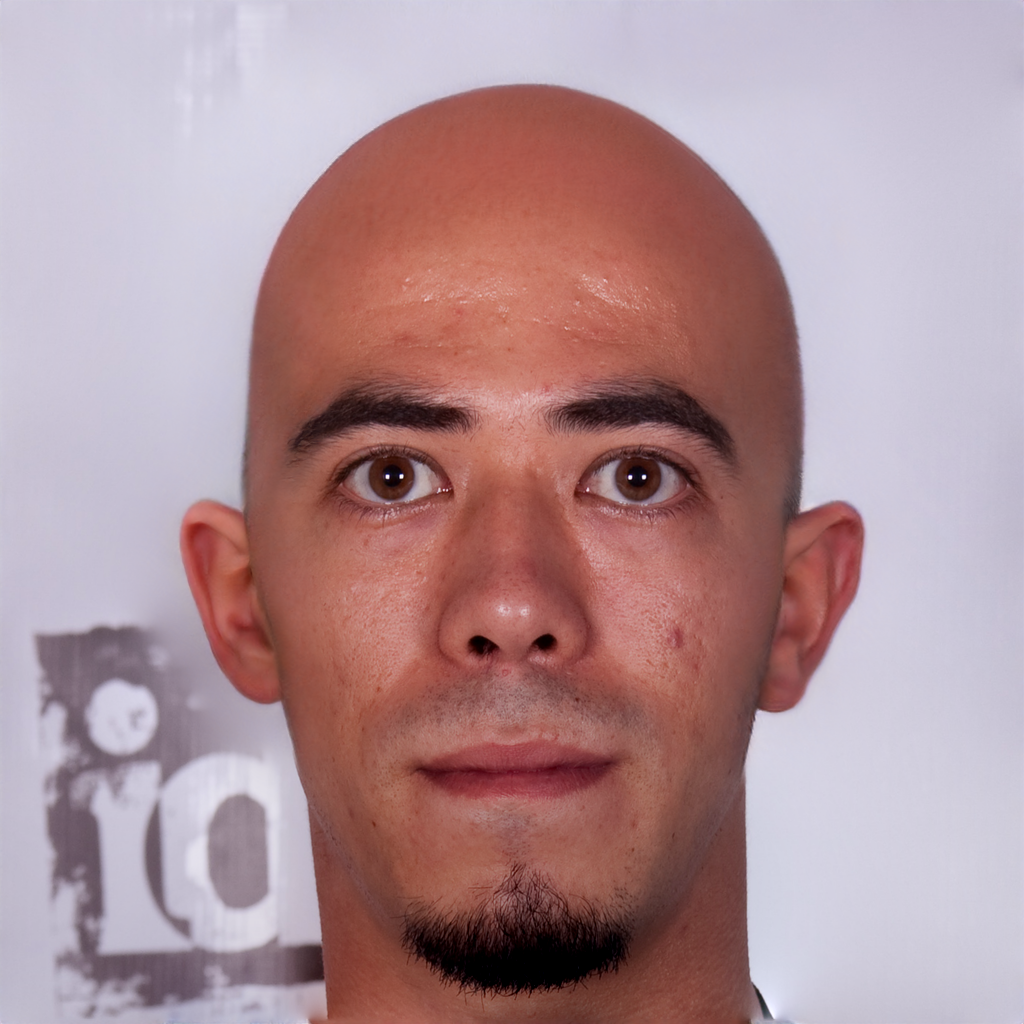

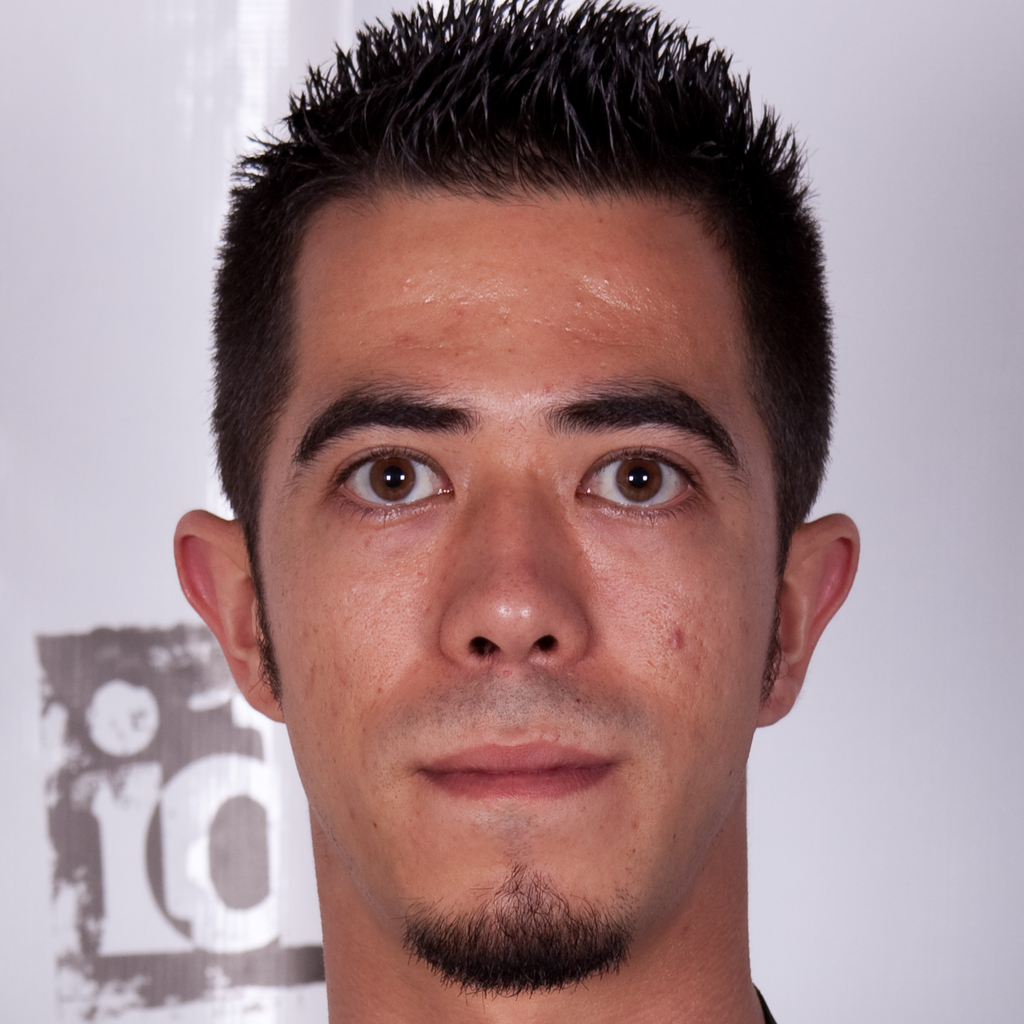

In [18]:
for res_path in glob.glob('./test_data/mapper_res/*'):
    res_img = cv2.imread(res_path)[:,:,::-1]
    #res_img = cv2.resize(res_img, (512,512))
    input_path = res_path.replace('mapper_res','origin')
    input_img = cv2.imread(input_path)[:,:,::-1]
    #input_img = cv2.resize(input_img, (1024, 1024))
    #visualize = np.concatenate([res_img,input_img], axis=1)
    res_im = Image.fromarray(res_img)
    input_im= Image.fromarray(input_img)
    display(res_im)
    display(input_im)